# Normalizing data for the SQL database

Normaling data to export into SQL database. Keep in mind, I won't be exporting all of the data there.

There are only around 100000 rows of data so we can just use prepare all everything through pandas and insert the tables to PostgreSQL in bulk.

Otherwise using staging tables would be a good idea.

In [1]:
# Module imports
# standard library imports

import os
import ast
import itertools
import re
import ast


# third-party imports
import numpy as np
import pandas as pd

# sqlalchemy
from sqlalchemy import create_engine

In [2]:
# connection settings
try:
    with open('../data/_credentials/db_config.txt', 'r') as f:
        db_config = eval(f.read())
    if not isinstance(db_config, dict):
        db_config = None
except:
    db_config = None

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(   db_config['user'],
                                                            db_config['pwd'],
                                                            db_config['host'],
                                                            db_config['port'],
                                                            db_config['db'])

In [3]:
# creating connector
engine = create_engine(connection_string)

In [4]:
# helper functions

## Database Schema


## ER Diagram
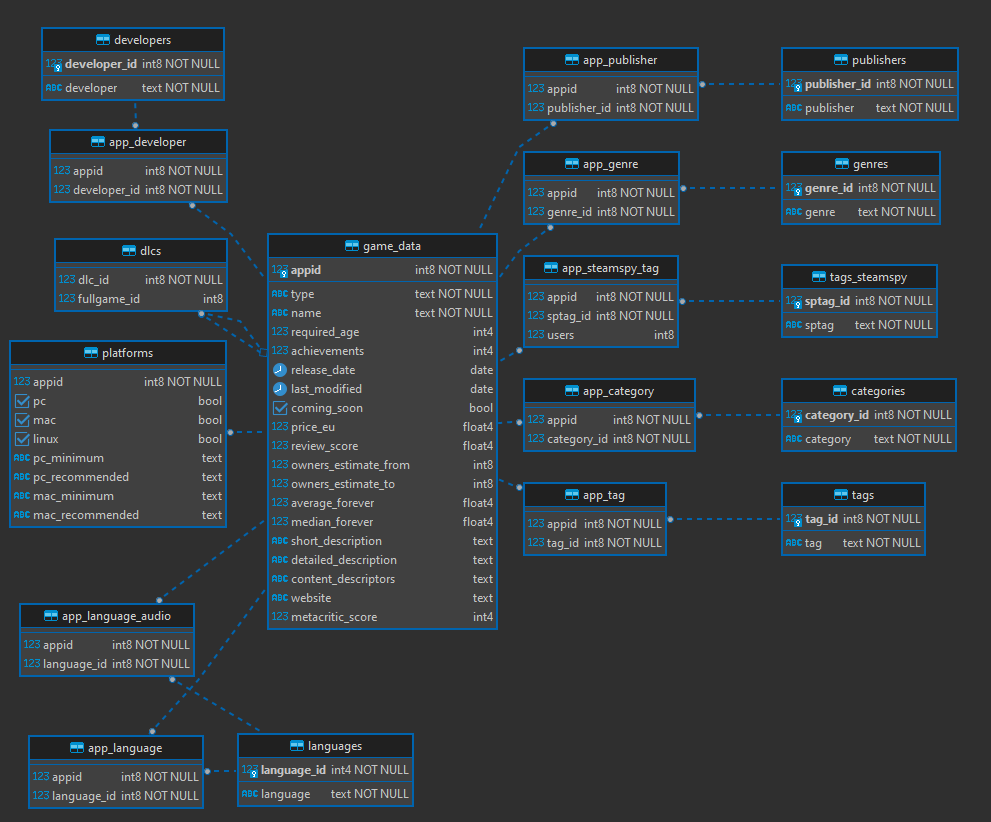

## Loading data into pandas

In [5]:
# Loading data tables
steam = pd.read_csv('../data/export/steam.csv', dtype={
    'fullgame': 'Int64',
    'total_positive': 'Int64',
    'total_negative': 'Int64'})
missing_ids = pd.read_csv('../data/export/missing_ids.csv')
steam_description_data = pd.read_csv('../data/export/steam_description_data.csv')
steam_media_data = pd.read_csv('../data/export/steam_media_data.csv')
steam_optional = pd.read_csv('../data/export/steam_optional.csv')
steam_packages_info = pd.read_csv('../data/export/steam_packages_info.csv')
steam_requirements_data = pd.read_csv('../data/export/steam_requirements_data.csv')
steam_support_info = pd.read_csv('../data/export/steam_support_info.csv')
steamspy_tag_data = pd.read_csv('../data/export/steamspy_tag_data.csv')

## Creating tables in database

## Creating fact tables

### game_data

Main table with the game data

| Field                | Type     | Nullable | Key     | Description                      |
| -------------------- | -------- | -------- | ------- | -------------------------------- |
| appid                | int      | False    | Primary | appid                            |
| type                 | text     | False    |         | application type (game/dlc/etc)  |
| name                 | text     | False    |         | application name                 |
| required_age         | int      | True     |         | minimum required age             |
| achievements         | int      | True     |         | number of achievements           |
| release_date         | datetime | True     |         | release date                     |
| last_modified        | datetime | False    |         | last modified date               |
| coming_soon          | boolean  | False    |         | is released                      |
| price_eu             | float64  | True     |         | price in eu for european region  |
| review_score         | float64  | True     |         | normalized review score          |
| owners_estimate_from | int      | True     |         | Estimated owners from (SteamSpy) |
| owners_estimate_to   | int      | True     |         | Estimated owners to (SteamSpy)   |
| average_forever      | float64  | True     |         | average playtime                 |
| median_forever       | float64  | True     |         | median playtime                  |
| short_description    | text     | True     |         | Short game description           |
| detailed_description | text     | True     |         | Detailed game description        |
| content_descriptors  | text     | True     |         | Rated content description        |
| website              | text     | True     |         | Game website                     |
| metacritic_score     | int      | True     |         | Metacritic review score          |

Merging tables on appid: 
* steam[[
    'appid', 'type', 'name', 'required_age', 'achievements', 'release_date', 'last_modified', 'coming_soon',
     'price_eu', 'review_score', 'owners_estimate_from', 'owners_estimate_to', 'average_forever', 'median_forever']]
* steam_description_data[['short_description', 'detailed_description']]
* steam_optional[['content_descriptors', 'metacritic_score']]
* steam_support_info[['website']]
    

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(steam.sample(2))

,appid,type,name,required_age,dlc,fullgame,supported_languages,developers,publishers,packages,platforms,categories,genres,achievements,release_date,last_modified,supported_audio,coming_soon,price,review_score,total_positive,total_negative,rating,owners,average_forever,median_forever,tags
38686,884470,game,Sunken,0,NaN,<NA>,['English'],['Trevor Madge'],['Trevor Madge'],"[281104, 332747]",['windows'],"['Single-player', 'Multi-player', 'PvP', 'Shar...","['Action', 'Casual', 'Indie']",0,2018-06-28 00:00:00,1545535676,NaN,False,2.39,0.0,5,0,70.844323,0-20000,0.0,0.0,"['Action', 'Indie', 'Casual']"
69014,1389430,game,Trash Can Dungeon - Battle Against The ZOO,0,NaN,<NA>,['Japanese'],"['KADOKAWA', '湿度ケイ']",['Komodo'],NaN,"['windows', 'mac']","['Single-player', 'Partial Controller Support']",['RPG'],0,2020-08-20 00:00:00,1657785037,NaN,False,0.00,0.0,1,1,50.000000,20000-50000,0.0,0.0,"['RPG', 'Action', 'Action RPG', 'Action-Advent..."


In [56]:
# transforming steam data
# release_date
steam['release_date'] = pd.to_datetime(steam['release_date'])
# last_modified
steam['last_modified'] = pd.to_datetime(steam['last_modified'])
# owners_estimate_from
# owners_estimate_to
steam[['owners_estimate_from', 'owners_estimate_to']] = steam['owners'].str.split('-', 1, expand=True)
steam['owners_estimate_from'] = steam['owners_estimate_from'].astype('float').astype('Int32')
steam['owners_estimate_to'] = steam['owners_estimate_to'].astype('float').astype('Int32')
# Merging tables. Appid should be unique for each table so left merging to steam is safe
game_data = steam[['appid', 'type', 'name', 'required_age', 'achievements', 'release_date', 'last_modified', 'coming_soon',
     'price', 'review_score', 'owners_estimate_from', 'owners_estimate_to', 'average_forever', 'median_forever'
     ]].merge(steam_description_data[['appid', 'short_description', 'detailed_description']], left_on='appid', right_on='appid', how='left')
game_data = game_data.merge(steam_optional[['appid', 'content_descriptors', 'metacritic_score']], left_on='appid', right_on='appid', how='left')
game_data = game_data.merge(steam_support_info[['appid', 'website']], left_on='appid', right_on='appid', how='left')
game_data['metacritic_score'] = game_data['metacritic_score'].astype('float').astype('Int32')
game_data = game_data.rename(columns={'price': 'price_eu'})

# swapping columns to the proper order
cols = list(game_data.columns)
swap1, swap2 = cols.index('metacritic_score'), cols.index('website')
cols[swap2], cols[swap1] = cols[swap1], cols[swap2]
game_data = game_data[cols]

In [65]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 0 to 108853
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   appid                 108854 non-null  int64         
 1   type                  108854 non-null  object        
 2   name                  108854 non-null  object        
 3   required_age          108854 non-null  int64         
 4   achievements          108854 non-null  int64         
 5   release_date          101103 non-null  datetime64[ns]
 6   last_modified         108854 non-null  datetime64[ns]
 7   coming_soon           108854 non-null  bool          
 8   price_eu              95883 non-null   float64       
 9   review_score          108854 non-null  float64       
 10  owners_estimate_from  105901 non-null  Int32         
 11  owners_estimate_to    105901 non-null  Int32         
 12  average_forever       105901 non-null  float64       
 13 

In [9]:
game_data.sample(3)

,appid,type,name,required_age,achievements,release_date,last_modified,coming_soon,price,review_score,owners_estimate_from,owners_estimate_to,average_forever,median_forever,short_description,detailed_description,content_descriptors,metacritic_score,website
107500,2097400,dlc,Fantasy Grounds - Pathfinder RPG - Pathfinder ...,0,0,2022-08-02,1970-01-01 00:00:01.659446899,True,16.79,0.0,<NA>,<NA>,NaN,NaN,Pathfinder RPG - Pathfinder Flip-Mat - Classic...,"<h2 class=""bb_tag"">Pathfinder RPG - Pathfinder...",NaN,NaN,https://www.fantasygrounds.com
64867,1314350,dlc,King of Vikings Adults Only 18+ Patch,0,0,2020-05-07,1970-01-01 00:00:01.588894068,False,0.00,0.0,0,20000,0.0,0.0,Experience King of Vikings adventures the way ...,Experience King of Vikings adventures the way ...,King of Vikings involves the main character ha...,NaN,http://kingkeygames.com/king-of-vikings/
35076,819880,game,SShield Reborn,0,0,2018-03-23,1970-01-01 00:00:01.521798347,False,2.99,0.0,0,20000,0.0,0.0,This Guitar Hero/Tap Tap Revenge] like game ex...,This <strong>Guitar Hero/Tap Tap Revenge]</str...,NaN,NaN,http://amanotes.com


### languages

| Field       | Type   | Nullable | Key     | Description |
| ----------- | ------ | -------- | ------- | ----------- |
| language_id | int    | False    | Primary | Language ID |
| language    | string | False    |         | Language    |

Get the unique languages from steam.supported_languages and steam.supported_audio, and sort them by value.

In [10]:
temp_df = steam[['appid', 'supported_languages', 'supported_audio']].copy()
# getting text languages
def language_cleanup(language_string):
    """
        Cleaning up language string from the unneeded characters and
        returning the list of cleaned up languages
        Parameters:
            language_string : string,
        Returns:
            list of cleaned up languages
    """
    re_mask = r'.((?:[A-Z][a-zA-Z \-\']*[a-z]+)+).?'
    try:
        language_string = language_string.replace('\\\'\\','')
        result1 = re.findall(re_mask, language_string)
        result = [x.strip() for x in result1]
    except:
        result = []
    return result

# cleaning up language strings. This is a temporary measure that should be removed after the clean up process is fixed
temp_df['supported_audio'] = temp_df['supported_audio'].apply(language_cleanup)
temp_df['supported_audio'] = temp_df['supported_audio'].fillna("").apply(list)
temp_df['supported_languages'] = temp_df['supported_languages'].apply(language_cleanup)                            
temp_df['supported_languages'] = temp_df['supported_languages'].fillna("").apply(list)

# getting the list of unique languages, removing nulls and sorting
language_df = pd.concat(
    [
        pd.DataFrame(temp_df['supported_languages'].explode().unique(), columns=['language']),
        pd.DataFrame(temp_df['supported_audio'].explode().unique(), columns=['language'])
    ]
).dropna().drop_duplicates().sort_values(by='language').reset_index(drop=True)
language_df.index.name='language_id'

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(language_df.head(10))

,language
language_id,
0,Afrikaans
1,Albanian
2,Amharic
3,Arabic
4,Armenian
5,Assamese
6,Azerbaijani
7,Bangla
8,Basque


### developers

| Field       | Type   | Nullable | Key     | Description |
| ------------ | ------ | -------- | ------- | ------------ |
| developer_id | int    | False    | Primary | Developer ID |
| developer    | string | False    |         | Developer    |

In [12]:
temp_df = steam[['appid', 'developers']].copy()
def list_check(value):
    try:
        result = ast.literal_eval(value)
    except:
        result = [value]
    return result
temp_df['developers'] = temp_df[temp_df['developers'].notnull()]['developers'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
developers_df = (
    pd.DataFrame(temp_df['developers'].explode().unique(), columns=['developer'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='developer')
    .reset_index(drop=True)
)
developers_df.index.name='developer_id'

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(developers_df.sample(10))

,developer
developer_id,
18500,INTETY
16497,Grannus Games
13693,Felipe Mauricio
22152,KodiiGames
44152,Whalesoft Entertainment
17799,Hidden Depths Games
23149,Les Canards Boiteux
32624,RGB SRL
41369,Tomas Gomez


### publishers

| Field        | Type   | Nullable | Key     | Description  |
| ------------ | ------ | -------- | ------- | ------------ |
| publisher_id | int    | False    | Primary | Publisher ID |
| publisher    | string | False    |         | Publisher    |

In [14]:
temp_df = steam[['appid', 'publishers']].copy()
def list_check(value):
    try:
        result = ast.literal_eval(value)
    except:
        result = [value]
    return result
temp_df['publishers'] = temp_df[temp_df['publishers'].notnull()]['publishers'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
publishers_df = (
    pd.DataFrame(temp_df['publishers'].explode().unique(), columns=['publisher'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='publisher')
    .reset_index(drop=True)
)
publishers_df.index.name='publisher_id'

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(publishers_df.tail(10))

,publisher
publisher_id,
41154,유진게임즈
41155,한국IT전문학교
41156,（Hong Kong）GKD
41157,（Hong Kong）GKD Game Studio
41158,（偽）苅田町役所
41159,𓃴 𓃵 𓃲
41160,𝓓𝓻𝔂❆𝓘𝓬𝓮
41161,👀
41162,📚瓜山书坊Guashan Bookshop


### platforms

#### platforms
| Field           | Type    | Nullable | Key     | Description |
| --------------- | ------- | -------- | ------- | ----------- |
| appid           | int     | False    | Primary | App ID      |
| windows         | boolean | False    |         |             |
| mac             | boolean | False    |         |             |
| linux           | boolean | False    |         |             |
| pc_minimum      | string  | True     |         |             |
| pc_recommended  | string  | True     |         |             |
| mac_minimum     | string  | True     |         |             |
| mac_recommended | string  | True     |         |             |

In [16]:
# copying dataframes
temp = steam[['appid', 'platforms']].copy()
temp1 = steam_requirements_data[['appid', 'pc_minimum', 'pc_recommended', 'mac_minimum', 'mac_recommended']].copy()
# parsing strings to lists
temp['platforms'] = temp['platforms'].apply(ast.literal_eval)
# exploding columns
temp = temp.explode('platforms')
# crosstabing to make boolean columns for each platform
temp = pd.crosstab(temp['appid'], temp['platforms'], dropna=False).replace({0: False, 1: True})
# mergingn with requirements
platforms_df = temp.merge(temp1, left_index=True, right_on='appid', how='left').reset_index(drop=True)
platforms_df = platforms_df[['appid', 'windows', 'mac', 'linux', 'pc_minimum', 'pc_recommended', 'mac_minimum', 'mac_recommended']]

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(platforms_df.tail(10))

,appid,windows,mac,linux,pc_minimum,pc_recommended,mac_minimum,mac_recommended
108844,2145860,True,False,False,NaN,NaN,NaN,NaN
108845,2145880,True,True,False,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...
108846,2146110,True,False,False,NaN,NaN,NaN,NaN
108847,2146230,True,False,False,NaN,NaN,NaN,NaN
108848,2146580,True,True,True,Additional Notes: System Supporting Visual Nov...,NaN,Additional Notes: System Supporting Visual Nov...,NaN
108849,2146600,True,False,False,NaN,NaN,NaN,NaN
108850,2147130,True,False,False,NaN,NaN,NaN,NaN
108851,2147260,True,False,False,NaN,NaN,NaN,NaN
108852,2147370,True,False,False,NaN,NaN,NaN,NaN
108853,2148230,True,False,False,NaN,NaN,NaN,NaN


### categories

| Field       | Type   | Nullable | Key     | Description |
| ----------- | ------ | -------- | ------- | ----------- |
| category_id | int    | False    | Primary | Category ID |
| category    | string | False    |         | Category    |

In [18]:
temp_df = steam[['appid', 'categories']].copy()

temp_df['categories'] = temp_df[temp_df['categories'].notnull()]['categories'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
categories_df = (
    pd.DataFrame(temp_df['categories'].explode().unique(), columns=['category'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='category')
    .reset_index(drop=True)
)
categories_df.index.name='category_id'

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(categories_df.tail(10))

,category
category_id,
27,Stats
28,Steam Achievements
29,Steam Cloud
30,Steam Leaderboards
31,Steam Trading Cards
32,Steam Turn Notifications
33,Steam Workshop
34,SteamVR Collectibles
35,VR Support


### genres

| Field    | Type   | Nullable | Key     | Description |
| -------- | ------ | -------- | ------- | ----------- |
| genre_id | int    | False    | Primary | Genre ID    |
| genre    | string | False    |         | Genre       |

In [20]:
temp_df = steam[['appid', 'genres']].copy()

temp_df['genres'] = temp_df[temp_df['genres'].notnull()]['genres'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
genres_df = (
    pd.DataFrame(temp_df['genres'].explode().unique(), columns=['genre'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='genre')
    .reset_index(drop=True)
)
genres_df.index.name='genre_id'

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(genres_df.tail(10))

,genre
genre_id,
23,Short
24,Simulation
25,Software Training
26,Sports
27,Strategy
28,Tutorial
29,Utilities
30,Video Production
31,Violent


### tags

| Field  | Type   | Nullable | Key     | Description |
| ------ | ------ | -------- | ------- | ----------- |
| tag_id | int    | False    | Primary | Tag ID      |
| tag    | string | False    |         | Tag         |

In [22]:
temp_df = steam[['appid', 'tags']].copy()

temp_df['tags'] = temp_df[temp_df['tags'].notnull()]['tags'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
tags_df = (
    pd.DataFrame(temp_df['tags'].explode().unique(), columns=['tag'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='tag')
    .reset_index(drop=True)
)
tags_df.index.name='tag_id'

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(tags_df.tail(10))

,tag
tag_id,
428,Well-Written
429,Werewolves
430,Western
431,Wholesome
432,Word Game
433,World War I
434,World War II
435,Wrestling
436,Zombies


### tags_steamspy

| Field    | Type   | Nullable | Key     | Description     |
| -------- | ------ | -------- | ------- | --------------- |
| sptag_id | int    | False    | Primary | SteamSpy Tag ID |
| sptag    | string | False    |         |                 |

In [24]:
tags_list = list(steamspy_tag_data.columns)
tags_list.remove('appid')
tags_list.sort()
sptags_df = pd.DataFrame(tags_list, columns=['sptag'])
sptags_df.index.name='sptag_id'

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sptags_df.tail(10))

,sptag
sptag_id,
428,web_publishing
429,well_written
430,werewolves
431,western
432,wholesome
433,word_game
434,world_war_i
435,world_war_ii
436,wrestling


## ER Diagram
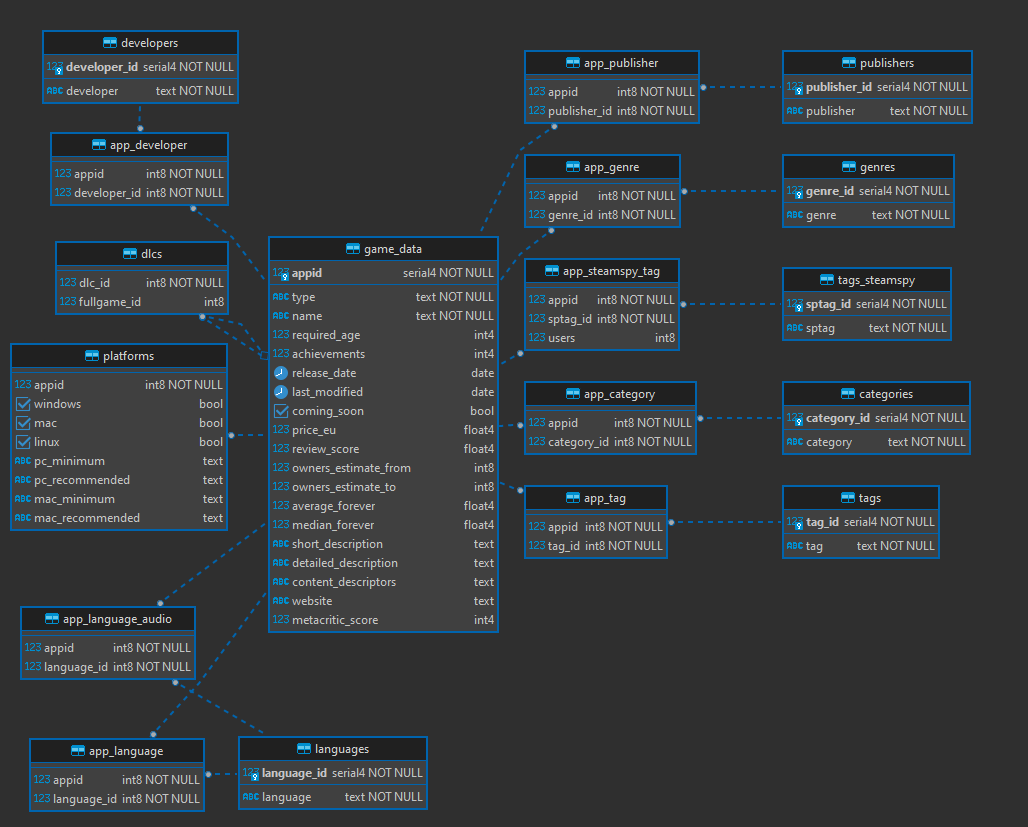

## Creating relations tables

### dlcs

| Field       | Type | Nullable | Key             | Description      |
| ----------- | ---- | -------- | --------------- | ---------------- |
| dlc_id      | int  | False    | game_data.appid | DLC App ID       |
| fullgame_id | int  | False    | game_data.appid | Main game App ID |

In [26]:
dlcs_df = steam.loc[steam.dlc.notnull(),['appid', 'dlc']].copy()

dlcs_df['dlc'] = dlcs_df['dlc'].apply(list_check)
dlcs_df = dlcs_df.explode('dlc')
dlcs_df['dlc'] = dlcs_df['dlc'].astype('Int64')

### app_language, app_language_audio

| Field       | Type | Nullable | Key                   | Description |
| ----------- | ---- | -------- | --------------------- | ----------- |
| appid       | int  | False    | game_data.appid       | App ID      |
| language_id | int  | False    | languages.language_id | Language ID |

Fields are the same for both tables.

We'll just get the unique appid -> language pairs here for a staging tables and get language_id through the SQL in the DB.

In [27]:
temp_df = steam[['appid', 'supported_languages', 'supported_audio']].copy()
# getting text languages
def language_cleanup(language_string):
    """
        Cleaning up language string from the unneeded characters and
        returning the list of cleaned up languages
        Parameters:
            language_string : string,
        Returns:
            list of cleaned up languages
    """
    re_mask = r'.((?:[A-Z][a-zA-Z \-\']*[a-z]+)+).?'
    try:
        language_string = language_string.replace('\\\'\\','')
        result1 = re.findall(re_mask, language_string)
        result = [x.strip() for x in result1]
    except:
        result = []
    return result

# cleaning up language strings. This is a temporary measure that should be removed after the clean up process is fixed
temp_df['supported_audio'] = temp_df['supported_audio'].apply(language_cleanup)
temp_df['supported_audio'] = temp_df['supported_audio'].fillna("").apply(list)
temp_df['supported_languages'] = temp_df['supported_languages'].apply(language_cleanup)                            
temp_df['supported_languages'] = temp_df['supported_languages'].fillna("").apply(list)

# creating dataframes
# app_language, app_language_audio
app_language_df = temp_df[['appid','supported_languages']].explode('supported_languages')
app_language_df = app_language_df.dropna(subset=['supported_languages'])
app_language_df = app_language_df.drop_duplicates()
app_language_audio_df = temp_df[['appid','supported_audio']].explode('supported_audio')
app_language_audio_df = app_language_audio_df.dropna(subset=['supported_audio'])
app_language_audio_df = app_language_audio_df.drop_duplicates()


In [28]:
app_language_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440647 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   appid                440647 non-null  int64 
 1   supported_languages  440647 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.1+ MB


In [29]:
app_language_df.sample(10)

,appid,supported_languages
2185,210043,Russian
94407,1813230,Finnish
61327,1252740,Spanish - Spain
56905,1183101,Polish
24259,627980,Japanese
45572,1003670,English
67397,1362157,Korean
30886,748980,Spanish - Spain
3842,258350,English
41518,933536,English


In [30]:
app_language_audio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116296 entries, 0 to 108846
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   appid            116296 non-null  int64 
 1   supported_audio  116296 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [31]:
app_language_audio_df.sample(10)

,appid,supported_audio
72546,1450310,Italian
86619,1692835,English
31305,753889,German
26308,666640,German
47060,1028260,Finnish
53790,1134413,Japanese
1739,200710,German
23700,617700,English
54849,1152000,Japanese
91533,1765670,Spanish - Latin America


### app_developer

| Field        | Type | Nullable | Key                     | Description  |
| ------------ | ---- | -------- | ----------------------- | ------------ |
| appid        | int  | False    | game_data.appid         | App ID       |
| developer_id | int  | False    | developers.developer_id | Developer ID |

In [32]:
temp_df = steam[['appid', 'developers']].copy()
temp_df['developers'] = temp_df[temp_df['developers'].notnull()]['developers'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_developer_df = temp_df.explode('developers')
app_developer_df = app_developer_df.dropna(subset=['developers'])
app_developer_df = app_developer_df.drop_duplicates()

In [33]:
app_developer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119415 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   appid       119415 non-null  int64 
 1   developers  119415 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [34]:
app_developer_df.sample(10)

,appid,developers
108071,2113370,Sprovieri Games
54602,1148000,Boogygames Studios
8970,355360,"White Giant RPG Studios, LLC"
97253,1864320,Piece Of Voxel
68470,1379800,Chongming Studio
105842,2057910,Interactive Pixel Entmt.
25340,648530,Choice of Games
87700,1703837,TigerQiuQiu
106553,2073630,Midge Makes Games
3060,232090,Tripwire Interactive


### app_publisher

| Field        | Type | Nullable | Key                     | Description  |
| ------------ | ---- | -------- | ----------------------- | ------------ |
| appid        | int  | False    | game_data.appid         | App ID       |
| publisher_id | int  | False    | publishers.publisher_id | Publisher ID |

In [35]:
temp_df = steam[['appid', 'publishers']].copy()
temp_df['publishers'] = temp_df[temp_df['publishers'].notnull()]['publishers'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_publisher_df = temp_df.explode('publishers')
app_publisher_df = app_publisher_df.dropna(subset=['publishers'])
app_publisher_df = app_publisher_df.drop_duplicates()

In [36]:
app_publisher_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113771 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   appid       113771 non-null  int64 
 1   publishers  113771 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


In [37]:
app_publisher_df.sample(10)

,appid,publishers
83631,1645780,Light of Creators
17599,510910,Attraction Studios
10375,378041,Feral Interactive (Mac/Linux)
68479,1379960,"GRAVITY GAME ARISE Co., Ltd."
33850,798430,Good Shepherd Entertainment
85115,1674040,CodeRenderX
18063,518920,Bossa Studios
72229,1444680,GungHo Online Entertainment America
17330,508404,BANDAI NAMCO Entertainment
81588,1608170,Tekkou Studios LLC


### app_category

| Field       | Type | Nullable | Key                    | Description |
| ----------- | ---- | -------- | ---------------------- | ----------- |
| appid       | int  | False    | game_data.appid        | App ID      |
| category_id | int  | False    | categories.category_id | Category ID |

In [38]:
temp_df = steam[['appid', 'categories']].copy()
temp_df['categories'] = temp_df[temp_df['categories'].notnull()]['categories'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_category_df = temp_df.explode('categories')
app_category_df = app_category_df.dropna(subset=['categories'])
app_category_df = app_category_df.drop_duplicates()

In [39]:
app_category_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453765 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   appid       453765 non-null  int64 
 1   categories  453765 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.4+ MB


In [40]:
app_category_df.sample(10)

,appid,categories
96894,1857090,Single-player
70452,1415830,Online PvP
12589,416420,Full controller support
13052,426210,PvP
71124,1426280,Single-player
54884,1152680,Steam Leaderboards
104947,2014500,MMO
2805,224165,Single-player
84857,1669210,Remote Play Together
87266,1699635,Steam Leaderboards


### app_genre

| Field    | Type | Nullable | Key             | Description |
| -------- | ---- | -------- | --------------- | ----------- |
| appid    | int  | False    | game_data.appid | App ID      |
| genre_id | int  | False    | genres.genre_id | Genre ID    |

In [41]:
temp_df = steam[['appid', 'genres']].copy()
temp_df['genres'] = temp_df[temp_df['genres'].notnull()]['genres'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_genre_df = temp_df.explode('genres')
app_genre_df = app_genre_df.dropna(subset=['genres'])
app_genre_df = app_genre_df.drop_duplicates()

In [42]:
app_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298943 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   appid   298943 non-null  int64 
 1   genres  298943 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.8+ MB


In [43]:
app_genre_df.sample(10)

,appid,genres
33051,784950,Free to Play
7473,331890,Massively Multiplayer
69833,1405220,Indie
83627,1645700,Adventure
38841,887370,Strategy
62704,1274540,Early Access
72578,1450830,Indie
67986,1371720,Simulation
21611,580590,Indie
96440,1848890,RPG


### app_tag

| Field  | Type   | Nullable | Key     | Description |
| ------ | ------ | -------- | ------- | ----------- |
| tag_id | int    | False    | Primary | Tag ID      |
| tag    | string | False    |         | Tag         |

In [44]:
temp_df = steam[['appid', 'tags']].copy()
temp_df['tags'] = temp_df[temp_df['tags'].notnull()]['tags'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_tag_df = temp_df.explode('tags')
app_tag_df = app_tag_df.dropna(subset=['tags'])
app_tag_df = app_tag_df.drop_duplicates()

In [45]:
app_tag_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659193 entries, 0 to 106760
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   appid   659193 non-null  int64 
 1   tags    659193 non-null  object
dtypes: int64(1), object(1)
memory usage: 15.1+ MB


In [46]:
app_tag_df.sample(10)

,appid,tags
34258,805710,Indie
94722,1818880,Sports
17079,502800,Great Soundtrack
76038,1511610,Action-Adventure
24842,637910,Indie
7477,331920,Simulation
15280,464610,Demons
74819,1490400,Simulation
58184,1202400,Indie
67273,1360700,Action-Adventure


### app_steamspy_tag

| Field    | Type | Nullable | Key                    | Description                |
| -------- | ---- | -------- | ---------------------- | -------------------------- |
| appid    | int  | False    | game_data.appid        | App ID                     |
| sptag_id | int  | False    | tags_steamspy.sptag_id | SteamSpy Tag ID            |
| users    | int  | False    |                        | Number of users with a tag |

In [47]:
app_steamspy_tag_df = steamspy_tag_data.melt(id_vars=['appid'])
app_steamspy_tag_df = app_steamspy_tag_df[app_steamspy_tag_df['value'] > 0].reset_index(drop=True)
app_steamspy_tag_df.columns = ['appid', 'sptag', 'users']

In [48]:
app_steamspy_tag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659193 entries, 0 to 659192
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   appid   659193 non-null  int64 
 1   sptag   659193 non-null  object
 2   users   659193 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 15.1+ MB


In [49]:
app_steamspy_tag_df.sample(10)

,appid,sptag,users
17030,1002,2d_fighter,45
572763,829734,sports,20
620241,1209200,time_management,11
169822,1656600,clicker,207
540129,244770,singleplayer,48
227813,1378320,early_access,21
588031,617810,strategy,28
458921,546400,quick_time_events,11
274132,339120,funny,7
60405,2008350,action,21


## Inserting data

### Creating tables

In [ ]:
query = """
-- public.categories definition

-- Drop table

-- DROP TABLE public.categories;

CREATE TABLE IF NOT EXISTS public.categories (
	category_id serial4 NOT NULL,
	category text NOT NULL,
	CONSTRAINT categories_pkey PRIMARY KEY (category_id)
);


-- public.developers definition

-- Drop table

-- DROP TABLE public.developers;

CREATE TABLE IF NOT EXISTS public.developers (
	developer_id serial4 NOT NULL,
	developer text NOT NULL,
	CONSTRAINT developers_pkey PRIMARY KEY (developer_id)
);


-- public.game_data definition

-- Drop table

-- DROP TABLE public.game_data;

CREATE TABLE IF NOT EXISTS public.game_data (
	appid serial4 NOT NULL,
	"type" text NOT NULL,
	"name" text NOT NULL,
	required_age int4 NULL,
	achievements int4 NULL,
	release_date date NULL,
	last_modified date NULL,
	coming_soon bool NULL,
	price_eu float4 NULL,
	review_score float4 NULL,
	owners_estimate_from int8 NULL,
	owners_estimate_to int8 NULL,
	average_forever float4 NULL,
	median_forever float4 NULL,
	short_description text NULL,
	detailed_description text NULL,
	content_descriptors text NULL,
	website text NULL,
	metacritic_score int4 NULL,
	CONSTRAINT game_data_pkey PRIMARY KEY (appid)
);


-- public.genres definition

-- Drop table

-- DROP TABLE public.genres;

CREATE TABLE IF NOT EXISTS public.genres (
	genre_id serial4 NOT NULL,
	genre text NOT NULL,
	CONSTRAINT genres_pkey PRIMARY KEY (genre_id)
);


-- public.languages definition

-- Drop table

-- DROP TABLE public.languages;

CREATE TABLE IF NOT EXISTS public.languages (
	language_id serial4 NOT NULL,
	"language" text NOT NULL,
	CONSTRAINT languages_pkey PRIMARY KEY (language_id)
);


-- public.publishers definition

-- Drop table

-- DROP TABLE public.publishers;

CREATE TABLE IF NOT EXISTS public.publishers (
	publisher_id serial4 NOT NULL,
	publisher text NOT NULL,
	CONSTRAINT publishers_pkey PRIMARY KEY (publisher_id)
);


-- public.tags definition

-- Drop table

-- DROP TABLE public.tags;

CREATE TABLE IF NOT EXISTS public.tags (
	tag_id serial4 NOT NULL,
	tag text NOT NULL,
	CONSTRAINT tags_pkey PRIMARY KEY (tag_id)
);


-- public.tags_steamspy definition

-- Drop table

-- DROP TABLE public.tags_steamspy;

CREATE TABLE IF NOT EXISTS public.tags_steamspy (
	sptag_id serial4 NOT NULL,
	sptag text NOT NULL,
	CONSTRAINT tags_steamspy_pkey PRIMARY KEY (sptag_id)
);


-- public.app_category definition

-- Drop table

-- DROP TABLE public.app_category;

CREATE TABLE IF NOT EXISTS public.app_category (
	appid int8 NOT NULL,
	category_id int8 NOT NULL,
	CONSTRAINT app_category_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_category_fk_1 FOREIGN KEY (category_id) REFERENCES public.categories(category_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.app_developer definition

-- Drop table

-- DROP TABLE public.app_developer;

CREATE TABLE IF NOT EXISTS public.app_developer (
	appid int8 NOT NULL,
	developer_id int8 NOT NULL,
	CONSTRAINT app_developer_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_developer_fk_1 FOREIGN KEY (developer_id) REFERENCES public.developers(developer_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.app_genre definition

-- Drop table

-- DROP TABLE public.app_genre;

CREATE TABLE IF NOT EXISTS public.app_genre (
	appid int8 NOT NULL,
	genre_id int8 NOT NULL,
	CONSTRAINT app_genre_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_genre_fk_1 FOREIGN KEY (genre_id) REFERENCES public.genres(genre_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.app_language definition

-- Drop table

-- DROP TABLE public.app_language;

CREATE TABLE IF NOT EXISTS public.app_language (
	appid int8 NOT NULL,
	language_id int8 NOT NULL,
	CONSTRAINT app_language_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_language_fk_1 FOREIGN KEY (language_id) REFERENCES public.languages(language_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.app_language_audio definition

-- Drop table

-- DROP TABLE public.app_language_audio;

CREATE TABLE IF NOT EXISTS public.app_language_audio (
	appid int8 NOT NULL,
	language_id int8 NOT NULL,
	CONSTRAINT app_language_audio_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_language_audio_fk_1 FOREIGN KEY (language_id) REFERENCES public.languages(language_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.app_publisher definition

-- Drop table

-- DROP TABLE public.app_publisher;

CREATE TABLE IF NOT EXISTS public.app_publisher (
	appid int8 NOT NULL,
	publisher_id int8 NOT NULL,
	CONSTRAINT app_publisher_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_publisher_fk_1 FOREIGN KEY (publisher_id) REFERENCES public.publishers(publisher_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.app_steamspy_tag definition

-- Drop table

-- DROP TABLE public.app_steamspy_tag;

CREATE TABLE IF NOT EXISTS public.app_steamspy_tag (
	appid int8 NOT NULL,
	sptag_id int8 NOT NULL,
	users int8 NULL,
	CONSTRAINT app_steamspy_tag_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_steamspy_tag_fk_1 FOREIGN KEY (sptag_id) REFERENCES public.tags_steamspy(sptag_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.app_tag definition

-- Drop table

-- DROP TABLE public.app_tag;

CREATE TABLE IF NOT EXISTS public.app_tag (
	appid int8 NOT NULL,
	tag_id int8 NOT NULL,
	CONSTRAINT app_tag_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT app_tag_fk_1 FOREIGN KEY (tag_id) REFERENCES public.tags(tag_id) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.dlcs definition

-- Drop table

-- DROP TABLE public.dlcs;

CREATE TABLE IF NOT EXISTS public.dlcs (
	dlc_id int8 NOT NULL,
	fullgame_id int8 NULL,
	CONSTRAINT dlcs_fk FOREIGN KEY (dlc_id) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE,
	CONSTRAINT dlcs_fk_1 FOREIGN KEY (fullgame_id) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE
);


-- public.platforms definition

-- Drop table

-- DROP TABLE public.platforms;

CREATE TABLE IF NOT EXISTS public.platforms (
	appid int8 NOT NULL,
	windows bool NULL,
	mac bool NULL,
	linux bool NULL,
	pc_minimum text NULL,
	pc_recommended text NULL,
	mac_minimum text NULL,
	mac_recommended text NULL,
	CONSTRAINT platforms_fk FOREIGN KEY (appid) REFERENCES public.game_data(appid) ON DELETE CASCADE ON UPDATE CASCADE
);
"""

In [ ]:
# creating tables
# commented as not required
# engine.execute(query)

### Inserting to fact tables

#### Inserting to game_data

In [59]:
# cleaning up table
engine.execute('DELETE FROM game_data')

In [67]:
# staging table
game_data.to_sql('game_data_staging', con=engine, index=False, if_exists='append', method='multi')

In [68]:
# inserting from staging table
engine.execute('''
    INSERT INTO game_data
        SELECT * 
        FROM game_data_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS game_data_staging')

In [70]:
# testing the results
query = "SELECT * FROM game_data LIMIT 10"
display(
    pd.io.sql.read_sql(query, con=engine)
    )

,appid,type,name,required_age,achievements,release_date,last_modified,coming_soon,price_eu,review_score,owners_estimate_from,owners_estimate_to,average_forever,median_forever,short_description,detailed_description,content_descriptors,website,metacritic_score
0,10,game,Counter-Strike,0,0,2000-11-01,1970-01-01,False,8.19,9.0,10000000,20000000,9699.0,184.0,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Includes intense violence and blood.,None,88.0
1,20,game,Team Fortress Classic,0,0,1999-04-01,1970-01-01,False,3.99,8.0,5000000,10000000,171.0,23.0,One of the most popular online action games of...,One of the most popular online action games of...,Includes intense violence and blood.,None,NaN
2,30,game,Day of Defeat,0,0,2003-05-01,1970-01-01,False,3.99,8.0,5000000,10000000,214.0,24.0,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,None,http://www.dayofdefeat.com/,79.0
3,40,game,Deathmatch Classic,0,0,2001-06-01,1970-01-01,False,3.99,8.0,5000000,10000000,99.0,9.0,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,None,None,NaN
4,50,game,Half-Life: Opposing Force,0,0,1999-11-01,1970-01-01,False,3.99,9.0,5000000,10000000,390.0,199.0,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,None,None,NaN
5,60,game,Ricochet,0,0,2000-11-01,1970-01-01,False,3.99,8.0,5000000,10000000,72.0,3.0,A futuristic action game that challenges your ...,A futuristic action game that challenges your ...,None,None,NaN
6,70,game,Half-Life,0,0,1998-11-08,1970-01-01,False,8.19,9.0,5000000,10000000,734.0,172.0,Named Game of the Year by over 50 publications...,Named Game of the Year by over 50 publications...,None,http://www.half-life.com/,96.0
7,80,game,Counter-Strike: Condition Zero,0,0,2004-03-01,1970-01-01,False,8.19,8.0,2000000,5000000,1108.0,30.0,"With its extensive Tour of Duty campaign, a ne...","With its extensive Tour of Duty campaign, a ne...",None,None,65.0
8,130,game,Half-Life: Blue Shift,0,0,2001-06-01,1970-01-01,False,3.99,8.0,10000000,20000000,209.0,148.0,Made by Gearbox Software and originally releas...,Made by Gearbox Software and originally releas...,None,None,71.0
9,220,game,Half-Life 2,0,33,2004-11-16,1970-01-01,False,8.19,9.0,10000000,20000000,902.0,358.0,1998. HALF-LIFE sends a shock through the game...,1998. HALF-LIFE sends a shock through the game...,None,http://www.half-life2.com,96.0


#### Inserting to languages

In [72]:
# cleaning up table
engine.execute('DELETE FROM languages')

In [73]:
# staging table
language_df.to_sql('languages_staging', con=engine, index=False, if_exists='append', method='multi')

In [76]:
# inserting from staging table
engine.execute('''
    INSERT INTO languages (language)
        SELECT language 
        FROM languages_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS languages_staging')

In [77]:
# testing the results
query = "SELECT * FROM languages LIMIT 10"
display(
    pd.io.sql.read_sql(query, con=engine)
    )

,language_id,language
0,1,Afrikaans
1,2,Albanian
2,3,Amharic
3,4,Arabic
4,5,Armenian
5,6,Assamese
6,7,Azerbaijani
7,8,Bangla
8,9,Basque
9,10,Belarusian


#### Inserting to developers

In [83]:
# cleaning up table
engine.execute('DELETE FROM developers')
# staging table
developers_df.to_sql('developers_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
engine.execute('''
    INSERT INTO developers (developer)
        SELECT developer 
        FROM developers_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS developers_staging')
# testing the results
query = "SELECT * FROM developers LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
    )

,developer_id,developer
0,1,!CyberApex (SkagoGames)
1,2,"""CR1STL"""
2,3,"""Nieko"""
3,4,"""RevDay Studio"""
4,5,#12
5,6,#LOL Entertainment
6,7,#NVJOB
7,8,#workshop
8,9,'Kill On Sight' Game development
9,10,'What Day is it?' Games


#### Inserting to publishers

In [85]:
# cleaning up table
engine.execute('DELETE FROM publishers')
# staging table
publishers_df.to_sql('publishers_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
engine.execute('''
    INSERT INTO publishers (publisher)
        SELECT publisher 
        FROM publishers_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS publishers_staging')
# testing the results
query = "SELECT * FROM publishers LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
    )

,publisher_id,publisher
0,1,
1,2,
2,3,Milestone S.r.l.
3,4,2:30 AM Studios
4,5,2MenStudio
5,6,3dm_live_wallpapers\t
6,7,5WORD Team
7,8,6 Toad Games
8,9,8Floor
9,10,"AIRLIB Co., Ltd."


#### Inserting to categories

In [87]:
# cleaning up table
engine.execute('DELETE FROM categories')
# staging table
categories_df.to_sql('categories_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
engine.execute('''
    INSERT INTO categories (category)
        SELECT category 
        FROM categories_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS categories_staging')
# testing the results
query = "SELECT * FROM categories LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
    )

,category_id,category
0,1,Captions available
1,2,Co-op
2,3,Commentary available
3,4,Cross-Platform Multiplayer
4,5,Downloadable Content
5,6,Full controller support
6,7,In-App Purchases
7,8,Includes Source SDK
8,9,Includes level editor
9,10,LAN Co-op


#### Inserting to genres

In [88]:
genres_df.sample(5)

,genre
genre_id,
6,Casual
12,Free to Play
21,Racing
1,Accounting
8,Documentary


In [89]:
# cleaning up table
engine.execute('DELETE FROM genres')
# staging table
genres_df.to_sql('genres_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
engine.execute('''
    INSERT INTO genres (genre)
        SELECT genre 
        FROM genres_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS genres_staging')
# testing the results
query = "SELECT * FROM genres LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
    )

,genre_id,genre
0,1,360 Video
1,2,Accounting
2,3,Action
3,4,Adventure
4,5,Animation & Modeling
5,6,Audio Production
6,7,Casual
7,8,Design & Illustration
8,9,Documentary
9,10,Early Access


#### Inserting to tags

In [90]:
tags_df.sample(5)

,tag
tag_id,
52,Benchmark
380,Text-Based
343,Snowboarding
213,Lovecraftian
260,Offroad


In [91]:
# cleaning up table
engine.execute('DELETE FROM tags')
# staging table
tags_df.to_sql('tags_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
engine.execute('''
    INSERT INTO tags (tag)
        SELECT tag 
        FROM tags_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS tags_staging')
# testing the results
query = "SELECT * FROM tags LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
    )

,tag_id,tag
0,1,1980s
1,2,1990's
2,3,2.5D
3,4,2D
4,5,2D Fighter
5,6,2D Platformer
6,7,360 Video
7,8,3D
8,9,3D Fighter
9,10,3D Platformer


#### Inserting to tags_steamspy

In [92]:
sptags_df.sample(5)

,sptag
sptag_id,
413,vehicular_combat
315,rogue_lite
161,gamemaker
81,cold_war
243,multiple_endings


In [93]:
# cleaning up table
engine.execute('DELETE FROM tags_steamspy')
# staging table
sptags_df.to_sql('tags_steamspy_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
engine.execute('''
    INSERT INTO tags_steamspy (sptag)
        SELECT sptag 
        FROM tags_steamspy_staging
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS tags_steamspy_staging')
# testing the results
query = "SELECT * FROM tags_steamspy LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
    )

,sptag_id,sptag
0,1,1980s
1,2,1990s
2,3,2.5d
3,4,2d
4,5,2d_fighter
5,6,2d_platformer
6,7,360_video
7,8,3d
8,9,3d_fighter
9,10,3d_platformer


### Adding and transforming relation tables

#### Inserting to dlcs

In [94]:
dlcs_df.sample(10)

,appid,dlc
8389,345440,378061
43287,962240,1667918
22783,601050,797750
19992,553520,1030221
3673,252690,1360970
17079,502800,588262
27702,690530,1207750
36030,838380,1119993
37228,859150,1860980
65951,1338770,1587595


In [97]:
game_data[game_data['appid'] == 323130]

,appid,type,name,required_age,achievements,release_date,last_modified,coming_soon,price_eu,review_score,owners_estimate_from,owners_estimate_to,average_forever,median_forever,short_description,detailed_description,content_descriptors,website,metacritic_score


In [98]:
# cleaning up table
engine.execute('DELETE FROM dlcs')
# staging table
dlcs_df.to_sql('dlcs_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO dlcs(dlc_id, fullgame_id)
        SELECT dlc, appid
        FROM dlcs_staging
        WHERE dlc IN (SELECT appid FROM game_data)
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS dlcs_staging')
# testing the results
query = "SELECT * FROM dlcs LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,dlc_id,fullgame_id
0,323150,380
1,323160,420
2,2120610,570
3,258750,1250
4,210943,1250
5,210945,1250
6,210936,1250
7,210933,1250
8,1257,1250
9,1256,1250


#### Inserting to app_language

In [104]:
# cleaning up table
engine.execute('DELETE FROM app_language')
# staging table
app_language_df.to_sql('app_language_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_language(appid, language_id)
        SELECT appid, languages.language_id
        FROM app_language_staging 
        INNER JOIN languages ON app_language_staging.supported_languages = languages.language
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_language_staging')
# testing the results
query = "SELECT * FROM app_language LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,language_id
0,10,20
1,10,25
2,10,28
3,10,40
4,10,48
5,10,75
6,10,83
7,10,92
8,20,20
9,20,25


#### Inserting to app_language_audio

In [106]:
app_language_audio_df.sample(10)

,appid,supported_audio
6968,323160,German
63504,1288440,English
14384,448850,English
68295,1376972,Finnish
21313,575640,German
94924,1822240,Italian
3114,234230,Italian
7434,331300,Italian
62464,1270830,Polish
18207,522070,German


In [113]:
# cleaning up table
engine.execute('DELETE FROM app_language_audio')
# staging table
app_language_audio_df.to_sql('app_language_audio_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_language_audio(appid, language_id)
        SELECT appid, languages.language_id
        FROM app_language_audio_staging 
        INNER JOIN languages ON app_language_audio_staging.supported_audio = languages.language
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_language_audio_staging')
# testing the results
query = "SELECT * FROM app_language LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,language_id
0,10,20
1,10,25
2,10,28
3,10,40
4,10,48
5,10,75
6,10,83
7,10,92
8,20,20
9,20,25


#### Inserting to app_developer

In [110]:
app_developer_df.sample(10)

,appid,developers
81906,1614440,Christopher Stair
61970,1262890,Moonray Studios
88350,1707510,Zero Points Focus
48392,1050700,Heinz Poetter
71027,1424400,BLUELEMON
23980,622355,Neil Birch
19488,545000,"KOEI TECMO GAMES CO., LTD."
13231,429120,Quarter Pound Studios
39516,897550,EviceGames
93254,1796630,Colossus Game Studio


In [114]:
# cleaning up table
engine.execute('DELETE FROM app_developer')
# staging table
app_developer_df.to_sql('app_developer_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_developer(appid, developer_id)
        SELECT appid, developers.developer_id
        FROM app_developer_staging 
        INNER JOIN developers ON app_developer_staging.developers = developers.developer
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_developer_staging')
# testing the results
query = "SELECT * FROM app_developer LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,developer_id
0,10,42907
1,20,42907
2,30,42907
3,40,42907
4,50,15781
5,60,42907
6,70,42907
7,80,42907
8,130,15781
9,220,42907


#### Inserting to app_publisher

In [115]:
app_publisher_df.sample(10)

,appid,publishers
106979,2084000,Roboatino
98934,1895330,Wayne A Dunn
67013,1356460,SIG Publishing
49291,1065110,Pavilion Media LLC
100818,1933400,Santiago (aka The Hipomancer)
41306,930570,Pixel Draw
107872,2107980,TigerQiuQiu
25847,658050,G. A. Williams
61409,1254193,Degica
78507,1556706,"CAPCOM Co., Ltd."


In [116]:
# cleaning up table
engine.execute('DELETE FROM app_publisher')
# staging table
app_publisher_df.to_sql('app_publisher_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_publisher(appid, publisher_id)
        SELECT appid, publishers.publisher_id
        FROM app_publisher_staging 
        INNER JOIN publishers ON app_publisher_staging.publishers = publishers.publisher
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_publisher_staging')
# testing the results
query = "SELECT * FROM app_publisher LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,publisher_id
0,10,35621
1,20,35621
2,30,35621
3,40,35621
4,50,35621
5,60,35621
6,70,35621
7,80,35621
8,130,35621
9,220,35621


#### Inserting to app_category

In [117]:
app_category_df.sample(10)

,appid,categories
51495,1099313,Downloadable Content
39568,898490,Single-player
60412,1236360,Steam Cloud
77358,1535780,Steam Achievements
3324,242110,Full controller support
50716,1088570,PvP
10027,372150,Remote Play Together
27758,691580,Single-player
29341,720400,Steam Cloud
106009,2061870,Downloadable Content


In [118]:
# cleaning up table
engine.execute('DELETE FROM app_category')
# staging table
app_category_df.to_sql('app_category_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_category(appid, category_id)
        SELECT appid, categories.category_id
        FROM app_category_staging 
        INNER JOIN categories ON app_category_staging.categories = categories.category
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_category_staging')
# testing the results
query = "SELECT * FROM app_category LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,category_id
0,317250,1
1,232430,1
2,274980,1
3,234250,1
4,80330,1
5,251110,1
6,312230,1
7,304380,1
8,288520,1
9,250990,1


#### Inserting to app_genre

In [119]:
app_genre_df.sample(10)

,appid,genres
71271,1428860,Indie
108652,2133110,Indie
56840,1182020,Sports
10231,375810,Action
108119,2114830,Casual
18234,522690,Adventure
68725,1384450,Casual
71226,1428070,Strategy
82848,1633390,Indie
79995,1580592,Action


In [120]:
# cleaning up table
engine.execute('DELETE FROM app_genre')
# staging table
app_genre_df.to_sql('app_genre_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_genre(appid, genre_id)
        SELECT appid, genres.genre_id
        FROM app_genre_staging 
        INNER JOIN genres ON app_genre_staging.genres = genres.genre
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_genre_staging')
# testing the results
query = "SELECT * FROM app_genre LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,genre_id
0,1434230,1
1,1454060,2
2,1515120,2
3,1434230,2
4,1522420,2
5,849690,2
6,750491,3
7,775860,3
8,729190,3
9,661110,3


#### Inserting to app_tag

In [121]:
app_tag_df.sample(10)

,appid,tags
11238,391600,Conversation
9332,361470,Action
12483,414550,FPS
54265,1142390,Female Protagonist
48833,1057720,Atmospheric
62332,1268370,Co-op
14352,448370,Violent
60867,1244470,Arcade
12693,418650,Shooter
66384,1346260,Pixel Graphics


In [122]:
# cleaning up table
engine.execute('DELETE FROM app_tag')
# staging table
app_tag_df.to_sql('app_tag_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_tag(appid, tag_id)
        SELECT appid, tags.tag_id
        FROM app_tag_staging 
        INNER JOIN tags ON app_tag_staging.tags = tags.tag
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_tag_staging')
# testing the results
query = "SELECT * FROM app_tag LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,tag_id
0,10,18
1,10,141
2,10,242
3,10,333
4,10,79
5,10,379
6,10,151
7,10,91
8,10,376
9,10,438


#### Inserting to app_steamspy_tag

In [123]:
app_steamspy_tag_df.sample(10)

,appid,sptag,users
459212,24460,rpg,27
244640,362380,family_friendly,128
40610,546180,action,24
118737,1009560,base_building,179
52801,1206050,action,103
356494,609110,local_co_op,38
609822,468070,tactical,184
262174,252550,first_person,47
159625,45750,character_customization,25
558441,1571540,singleplayer,25


In [124]:
# cleaning up table
engine.execute('DELETE FROM app_steamspy_tag')
# staging table
app_steamspy_tag_df.to_sql('app_steamspy_tag_staging', con=engine, index=False, if_exists='append', method='multi')
# inserting from staging table
# removing dlc_ids that are not present in the data
engine.execute('''
    INSERT INTO app_steamspy_tag(appid, sptag_id, users)
        SELECT appid, tags_steamspy.sptag_id, users
        FROM app_steamspy_tag_staging 
        INNER JOIN tags_steamspy ON app_steamspy_tag_staging.sptag = tags_steamspy.sptag
''')
# removing staging table
engine.execute('DROP TABLE IF EXISTS app_steamspy_tag_staging')
# testing the results
query = "SELECT * FROM app_steamspy_tag LIMIT 10"

display(
    pd.io.sql.read_sql(query, con=engine)
)

,appid,sptag_id,users
0,10,1,265
1,1500,1,167
2,10100,1,12
3,19200,1,167
4,63620,1,101
5,203990,1,63
6,204630,1,87
7,217270,1,12
8,219150,1,1356
9,227380,1,33


In [129]:
app_steamspy_tag_df.shape[0]

659193

## Testing data

#### Row counts

In [125]:
# checking item counts

tables = [
    'game_data',
    'languages',
    'developers',
    'publishers',
    'platforms',
    'categories',
    'genres',
    'tags',
    'tags_steamspy',
    'dlcs',
    'app_language',
    'app_language_audio',
    'app_developer',
    'app_publisher',
    'app_category',
    'app_genre',
    'app_tag',
    'app_steamspy_tag'
]
for table in tables:
    # testing the results
    query = f"SELECT COUNT(*) FROM {table}"
    display(
        pd.io.sql.read_sql(query, con=engine).style.set_caption(f"{table} rowcount")
    )

,count
0,108854


,count
0,106


,count
0,49493


,count
0,41164


,count
0,0


,count
0,37


,count
0,33


,count
0,438


,count
0,438


,count
0,101172


,count
0,440647


,count
0,116296


,count
0,119415


,count
0,113771


,count
0,453765


,count
0,298943


,count
0,659193


,count
0,659193


#### Checking table joins

In [136]:
# Top-20 tags for tag data from SteamSpy
query = """
    SELECT sptag SteamSpy_Tag,
           COUNT(users) AS tags_count
    FROM tags_steamspy t
    INNER JOIN app_steamspy_tag at ON t.sptag_id = at.sptag_id
    GROUP BY sptag
    ORDER BY COUNT(users) DESC
    LIMIT 20
    """

display(
    pd.io.sql.read_sql(query, con=engine)
    .style.set_caption("Top-20 tags for tag data from SteamSpy")
)

,steamspy_tag,tags_count
0,indie,38317
1,action,27887
2,singleplayer,25682
3,casual,24836
4,adventure,24488
5,simulation,14522
6,2d,13640
7,strategy,13575
8,rpg,11398
9,puzzle,9309


In [147]:
# Top-20 tags (not from SteamSpy) for games with Metacritic score > 90
query = """
    SELECT t.tag Steam_Tag,
           COUNT(DISTINCT gd.appid) AS Games_count
    FROM (SELECT appid FROM game_data WHERE metacritic_score > 90 AND type='game') gd
    INNER JOIN app_tag at ON gd.appid=at.appid
    INNER JOIN tags t ON at.tag_id=t.tag_id
    GROUP BY t.tag_id
    ORDER BY COUNT(DISTINCT gd.appid) DESC
    LIMIT 20
    """

display(
    pd.io.sql.read_sql(query, con=engine)
    .style.set_caption("Top-20 tags (not from SteamSpy) for games with Metacritic score > 90")
)

,steam_tag,games_count
0,Singleplayer,51
1,Action,46
2,Atmospheric,40
3,Adventure,37
4,Story Rich,36
5,Great Soundtrack,33
6,Multiplayer,29
7,Classic,25
8,Shooter,24
9,First-Person,24


In [146]:
# Top-5 genres for games with Metacritic score > 90
query = """
    SELECT g.genre Genre,
           COUNT(DISTINCT gd.appid) AS Games_count
    FROM (SELECT appid FROM game_data WHERE metacritic_score > 90 AND  type = 'game') gd
    INNER JOIN app_genre ag ON gd.appid=ag.appid
    INNER JOIN genres g ON ag.genre_id=g.genre_id
    GROUP BY g.genre_id
    ORDER BY COUNT(DISTINCT gd.appid) DESC
    LIMIT 5
    """

display(
    pd.io.sql.read_sql(query, con=engine)
    .style.set_caption("Top-5 categories for games with Metacritic score > 90")
)

,genre,games_count
0,Action,36
1,RPG,20
2,Adventure,15
3,Indie,11
4,Strategy,9


In [145]:
game_data.sample(5)

,appid,type,name,required_age,achievements,release_date,last_modified,coming_soon,price_eu,review_score,owners_estimate_from,owners_estimate_to,average_forever,median_forever,short_description,detailed_description,content_descriptors,website,metacritic_score
28896,712090,game,Don't Feed,0,10,2017-10-10,1970-01-01 00:00:01.573604289,False,0.00,6.0,0,20000,0.0,0.0,&quot;Don't Feed&quot; is inspired by popular ...,&quot;Don't Feed&quot; is inspired by popular ...,NaN,https://ravinia.io,<NA>
18866,533300,game,Zup!,0,118,2016-10-04,1970-01-01 00:00:01.572107769,False,1.59,8.0,500000,1000000,133.0,121.0,Minimal physical puzzle with explosions,"<img src=""https://cdn.akamai.steamstatic.com/s...",NaN,http://quietriver.info/,<NA>
88237,1705560,game,Kitty Adventure,0,4,2021-08-11,1970-01-01 00:00:01.628703444,False,0.79,7.0,0,20000,0.0,0.0,Kitty Adventure is a classic platformer overlo...,Kitty Adventure is a classic platformer overlo...,NaN,NaN,<NA>
105397,2025454,dlc,The Legend of Heroes: Kuro no Kiseki - Sepith ...,0,0,2022-07-27,1970-01-01 00:00:01.658934277,True,1.99,0.0,<NA>,<NA>,NaN,NaN,A set of Sepith ore items used to synthesize q...,A set of Sepith ore items used to synthesize q...,NaN,NaN,<NA>
106766,2078820,game,Gummy Jump,0,17,2022-08-02,1970-01-01 00:00:01.659837232,True,0.79,0.0,0,20000,0.0,0.0,you are a gummy where you have to get to the t...,"In this 2D platformer, you are a gummy, you ar...",NaN,NaN,<NA>


In [157]:
# Games from developers having more than one game with average review score 9 and higher across all of their games
query = """
    WITH cte AS (
        SELECT   gd.appid,
                 name,
                 review_score,
                 release_date,
                 developer
        FROM     (SELECT appid, name, review_score, release_date 
                  FROM game_data WHERE type='game') gd
        INNER JOIN app_developer ad ON gd.appid=ad.appid
        INNER JOIN developers d ON ad.developer_id=d.developer_id
    ),
    cte2 AS (
        SELECT *,
               AVG(review_score) OVER (PARTITION BY developer) avg_review_score,
               COUNT(appid) OVER (PARTITION BY developer) games_count
        FROM cte
    )
    SELECT * 
    FROM cte2
    WHERE avg_review_score >= 9.0
          AND games_count > 1
    ORDER BY developer ASC, release_date DESC
    """

display(
    pd.io.sql.read_sql(query, con=engine)
    .style.set_caption("Top-5 categories for games with Metacritic score > 90")
)

,appid,name,review_score,release_date,developer,avg_review_score,games_count
0,1161870,Epiphyllum in Love,9.000000,2020-03-16,#workshop,9.000000,3
1,944020,Dream Ending,9.000000,2019-07-22,#workshop,9.000000,3
2,1002560,Tiny Snow,9.000000,2019-02-27,#workshop,9.000000,3
3,1123450,Chicory: A Colorful Tale,9.000000,2021-06-10,A Shell in the Pit,9.000000,2
4,530320,Wandersong,9.000000,2018-09-27,A Shell in the Pit,9.000000,2
5,1067850,Kindergarten 2,9.000000,2019-07-29,Con Man Games,9.000000,2
6,589590,Kindergarten,9.000000,2017-06-15,Con Man Games,9.000000,2
7,1127500,Mini Motorways,9.000000,2021-07-20,Dinosaur Polo Club,9.000000,2
8,287980,Mini Metro,9.000000,2015-11-06,Dinosaur Polo Club,9.000000,2
9,793350,Swarmlake,9.000000,2018-03-12,Dominique Grieshofer,9.000000,2
